In [30]:
import pandas as pd
from collections import Counter
from transformers import BertModel, BertTokenizer
import torch
import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan


# View the Data

In [2]:
raw_dataset = pd.read_csv("probetag_buchungscodes_datensatz.csv")
raw_dataset

,Unnamed: 0,PartNumber,Description,Count,SumPrice,BookingCode,DocumentId
0,0,AVFC,Fehlercode auslesen/zurücksetzen,0.3,NaN,E101,61784A9D-1DFF-4D7F-832E-7A8ABA731A92
1,1,570500076D842,Starterbatterie BLUE dynamic\r\nEFB,1.0,207.58,C201,6C4AD3D3-84D6-497B-913B-7D4170253234
2,2,99999999,Flüssigkeitsmanagment,NaN,14.00,E405,0EBC8A63-96D5-434A-B819-0FDD5C58DCD5
3,3,N10437301,BATTERIE,1.0,3.30,I104,A6F29568-3477-40D0-B6B2-6B73C6DCDB67
4,4,66126912985,"Knopfzelle 3,2 V-\r\nCR2032",1.0,3.33,I104,4B9D3ED4-DA1E-4566-BBD7-72D30169A244
...,...,...,...,...,...,...,...
3668,3668,SG1387929,BREMSSCHEIBE VA FUER OPEL,2.0,245.22,F208,3C867E19-1658-4629-96DC-1ADF39CA80C1
3669,3669,17013550,Motoroel prüfen u.ergänzen,NaN,13.60,E405,FB1D6F98-9E62-4B16-BE72-A68D0C3EA3ED
3670,3670,A9079001703,Steuergerät,1.0,834.31,I905,6B1CE157-F416-42A8-A660-86B17F86913D
3671,3671,Q32005,GLÜHLAMPEN SETGT20\r\nGlühlampen SetGT200,1.0,55.50,L502,AB803EAB-AD31-479E-81C1-4B1E584FC75F


In [3]:
part_numbers = Counter(raw_dataset["PartNumber"])

len(part_numbers)

1285

In [4]:
description = Counter(raw_dataset["Description"])

len(description)

1531

In [45]:
booking_code = Counter(raw_dataset["BookingCode"])

len(booking_code), booking_code

(100,
 Counter({'C201': 332,
          'E416': 305,
          'P149': 217,
          'I104': 199,
          'E412': 164,
          'E326': 163,
          'E102': 156,
          'A101': 143,
          'C103': 115,
          'E413': 111,
          'F208': 96,
          'G116': 94,
          'P165': 89,
          'E441': 85,
          'E211': 81,
          'G109': 78,
          'E249': 74,
          'F214': 71,
          'E101': 62,
          'E220': 58,
          'E319': 57,
          'G315': 56,
          'E325': 52,
          'R106': 45,
          'L502': 43,
          'E418': 41,
          'E402': 37,
          'E405': 34,
          'L102': 30,
          'F506': 25,
          'L103': 22,
          'E310': 20,
          'R210': 19,
          'P404': 19,
          'P722': 18,
          'X608': 17,
          'E247': 16,
          'T103': 16,
          'W501': 15,
          'E318': 15,
          'L118': 15,
          'E421': 15,
          'P420': 14,
          'E422': 14,
          'I905'

In [ ]:
# problem some Booking Codes appear only once in the dataset

In [6]:
document_id = Counter(raw_dataset["DocumentId"])

len(document_id)

2135

In [7]:
# Can function as Identifier

untitled = Counter(raw_dataset["Unnamed: 0"])

len(untitled)

3673

In [8]:
# Rename Indentifier

cols = raw_dataset.columns.tolist()

cols[0] = "ID"

dataset = pd.DataFrame(raw_dataset)

dataset.columns = cols

In [9]:
# Clean Descriptions

dataset["Description"] = dataset["Description"].fillna("")

# Generating Bert Embeddings from the Description Texts

In [10]:

tokenizer = BertTokenizer.from_pretrained('bert-base-german-cased')
BERT = BertModel.from_pretrained('bert-base-german-cased')
BERT.eval()

def get_bert_embeddings(sentences, tokenizer, model):
    encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**encoded_input)
    cls_embeddings = outputs.last_hidden_state[:, 0, :]  # First Token = CLS Token
    
    return cls_embeddings


In [11]:
description_embeddings = get_bert_embeddings(dataset["Description"].unique().tolist(), tokenizer, BERT)

In [12]:
embeddings_dict = {description: embedding.numpy() for description, embedding in zip(dataset["Description"].unique().tolist(), description_embeddings)}

In [13]:
dataset["descriptionEmbeddings"] = dataset["Description"].apply(lambda x: embeddings_dict[x])

In [28]:
# Extracting Per Item Feature

def calc_per_item_price(sum_price, count):
    if count != count or count <=0:
        # count is nan
        if sum_price == sum_price:
            # sum_price is not nan
            return sum_price

    if sum_price!=sum_price:
        # nan price is set to a low negative number to allow easys destinction by the model
        return -1

    price = sum_price/count

    return price

prices = []
for count, sum_price in zip(dataset["Count"], dataset["SumPrice"]):
    prices.append(calc_per_item_price(sum_price, count))

# normalize prices

prices = np.array(prices)
prices_norm = (prices - np.mean(prices)) / np.std(prices)

dataset["Price"] = prices
dataset["NormPrice"] = prices_norm

# Initial Clustering

Embeddings shape: (3673, 768)


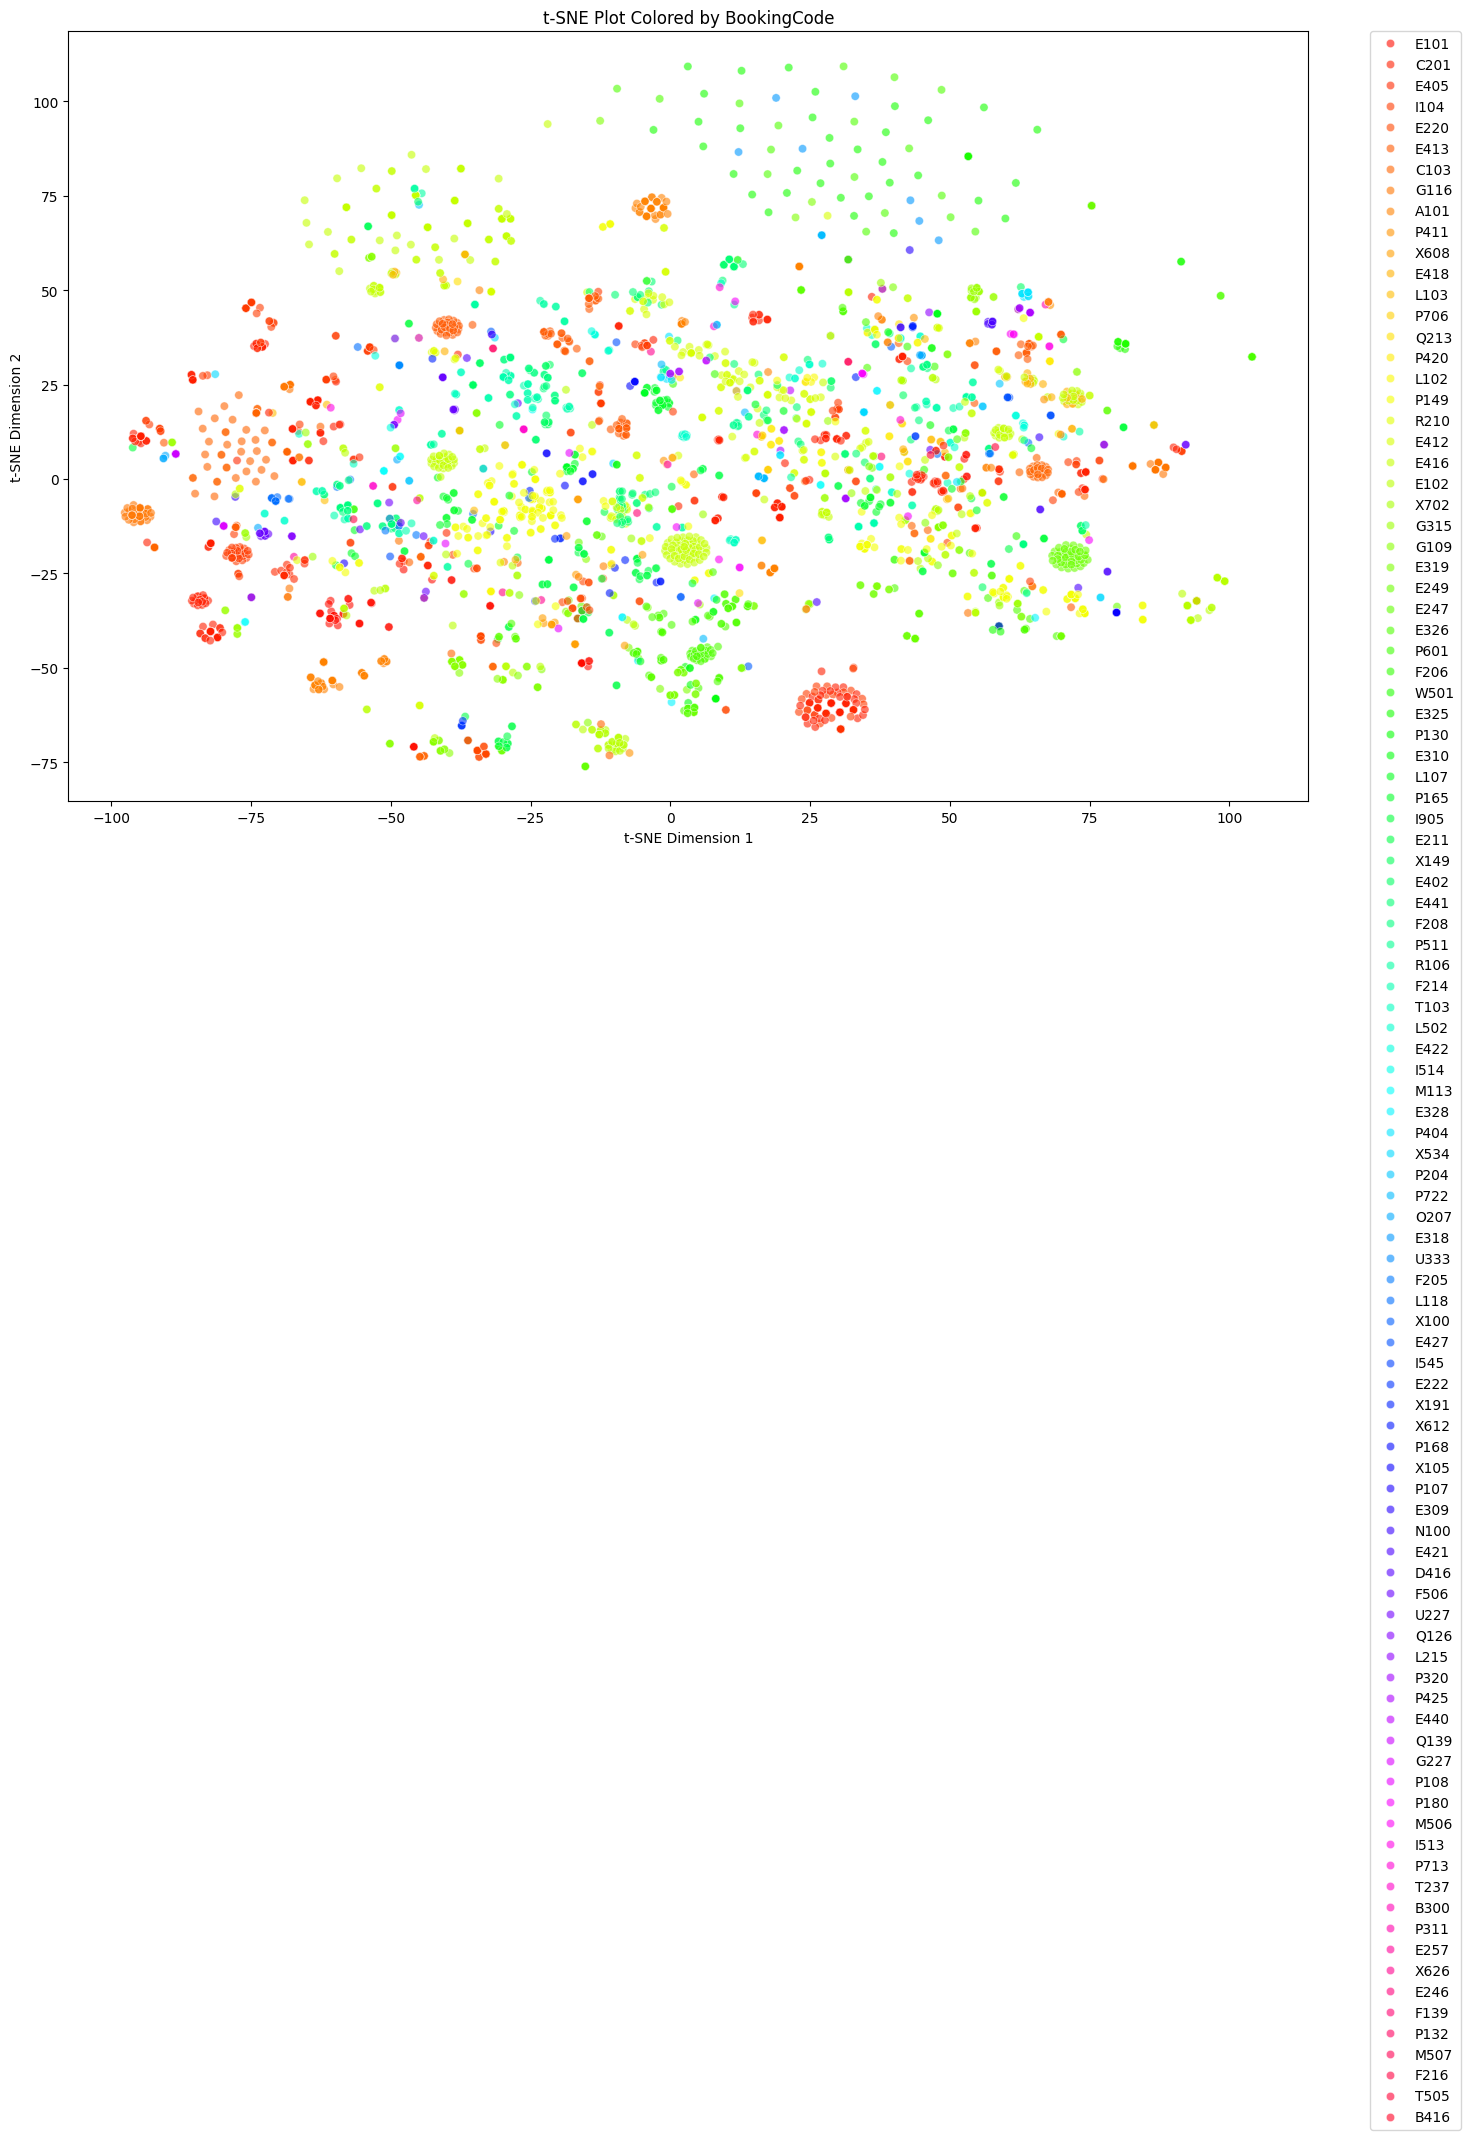

In [16]:
# Initial Clustering
cluster_ds = pd.DataFrame(dataset)

embeddings = np.vstack(cluster_ds['descriptionEmbeddings'].values)
print(f'Embeddings shape: {embeddings.shape}') 

tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
tsne_results = tsne.fit_transform(embeddings)

cluster_ds['tsne-2d-one'] = tsne_results[:, 0]
cluster_ds['tsne-2d-two'] = tsne_results[:, 1]

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x='tsne-2d-one', y='tsne-2d-two',
    hue='BookingCode',
    palette=sns.color_palette("hsv", 100),
    data=cluster_ds,
    legend='full',
    alpha=0.6
)
plt.title('t-SNE Plot Colored by BookingCode')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [17]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=10, min_samples=1, prediction_data=True)

cluster_labels = clusterer.fit_predict(embeddings)  

cluster_ds['hdbscan_cluster'] = cluster_labels

num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
print(f'Number of clusters (HDBSCAN): {num_clusters}')


/mnt/Lukas/Übung/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/Lukas/Übung/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Number of clusters (HDBSCAN): 104


/tmp/ipykernel_1868486/2756711592.py:5: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.scatterplot(
/tmp/ipykernel_1868486/2756711592.py:5: UserWarning: 
The palette list has fewer values (104) than needed (105) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(


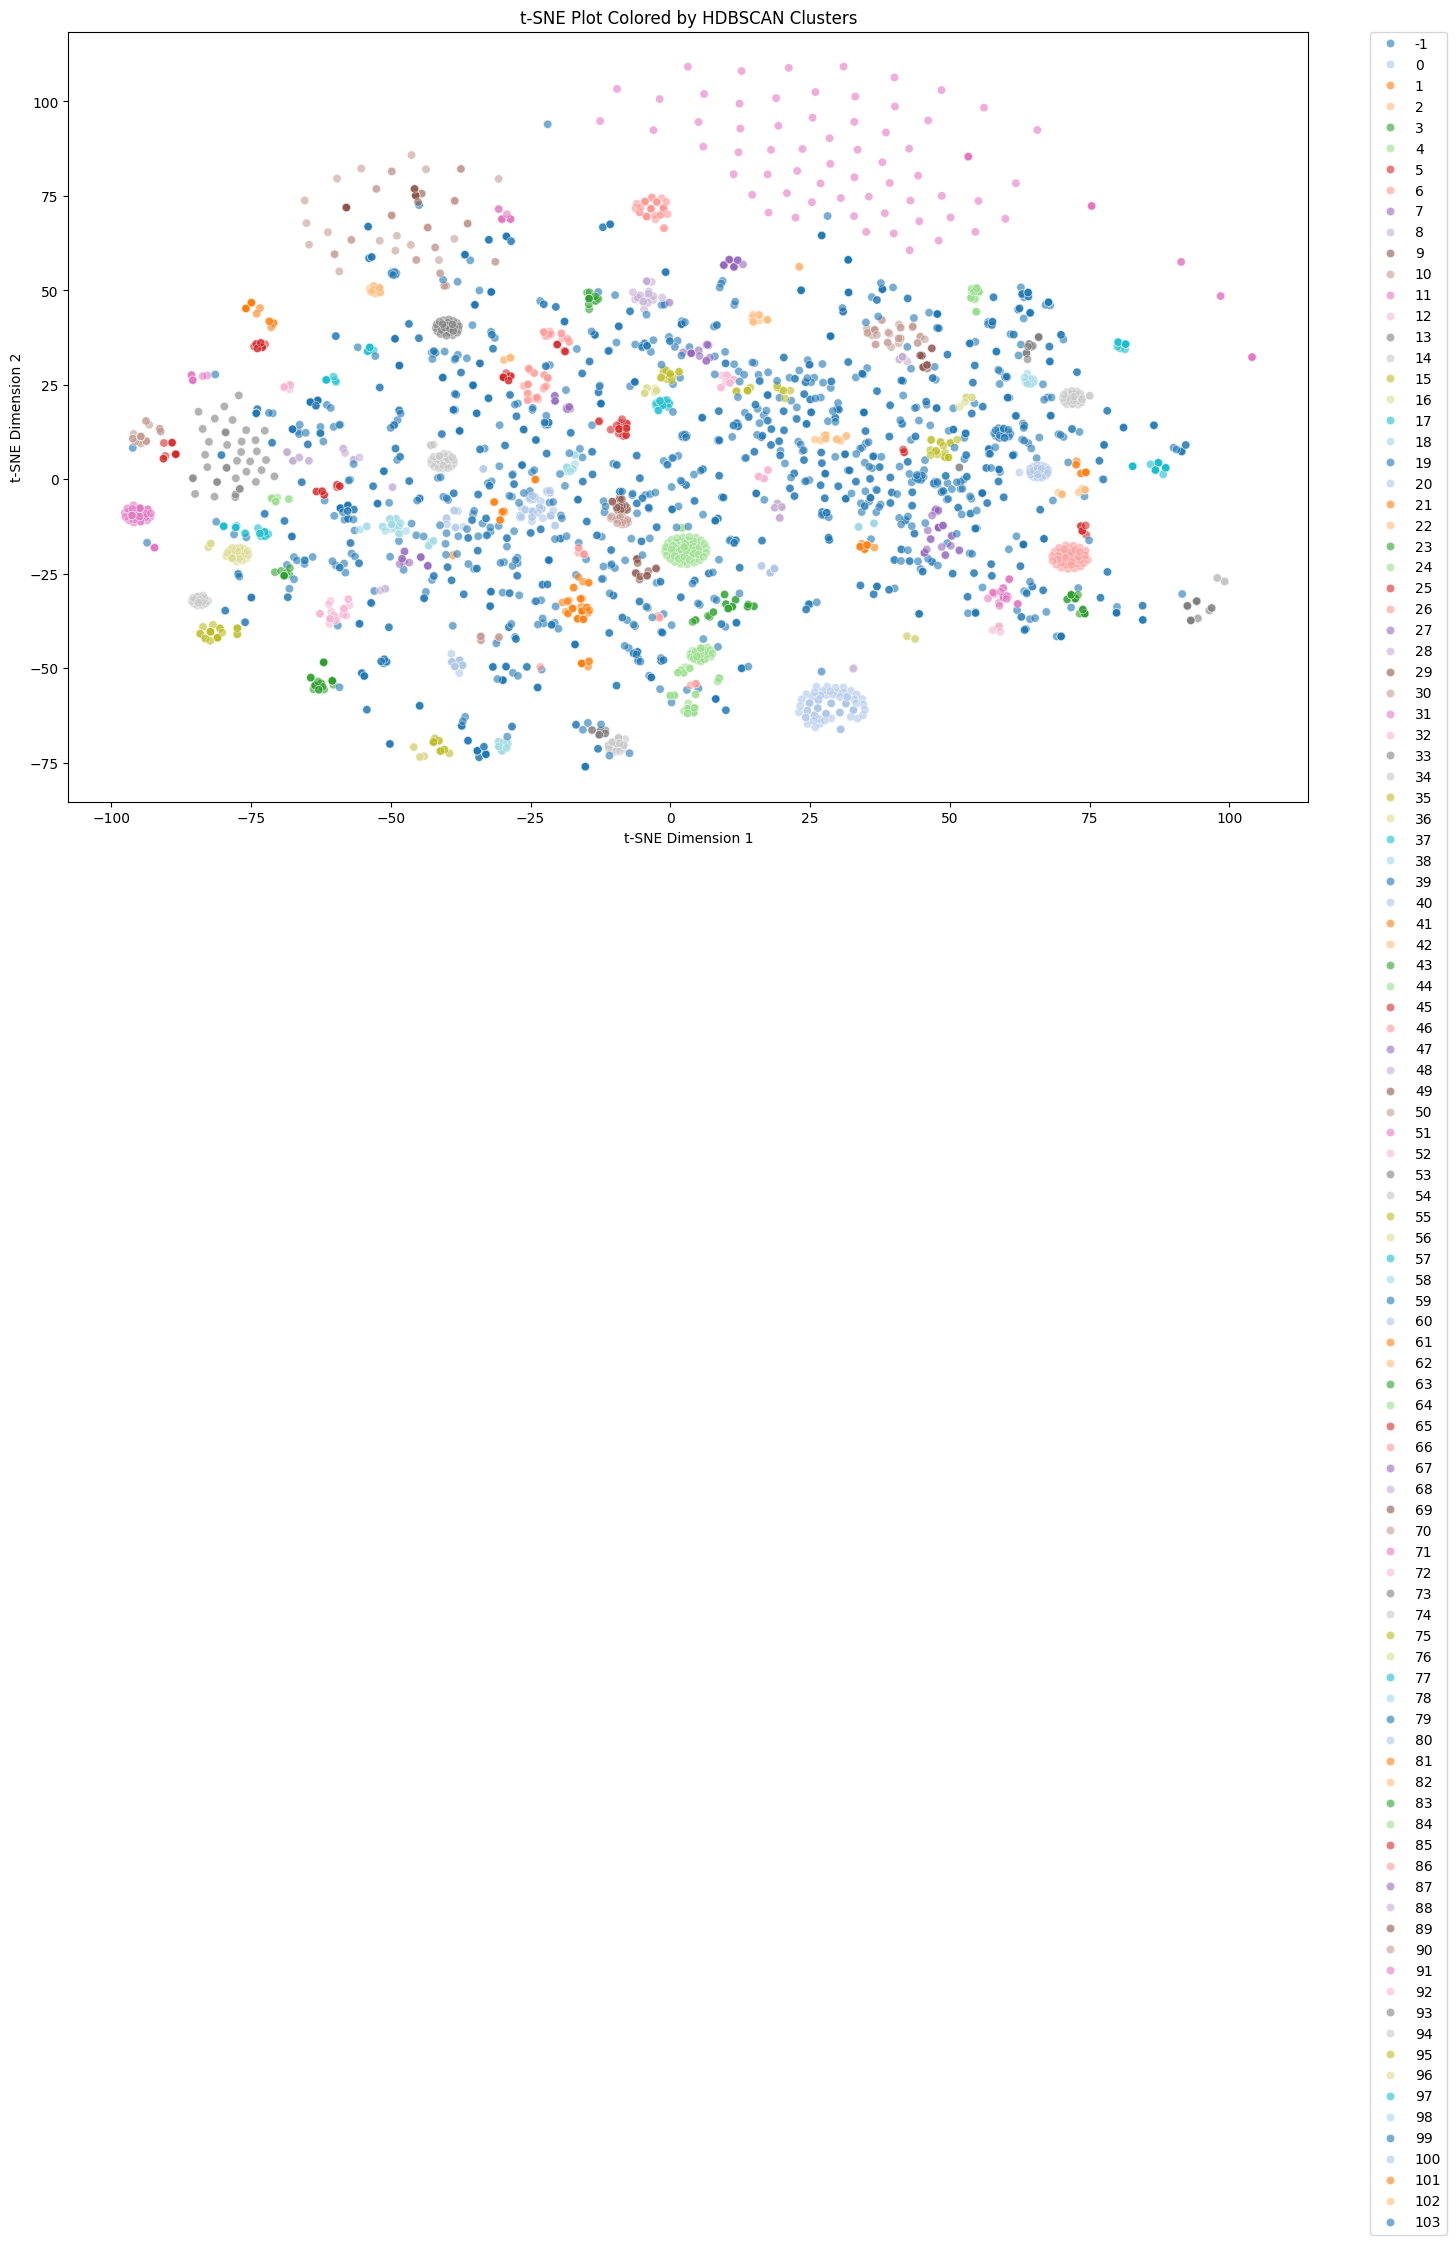

In [18]:

palette = sns.color_palette("tab20", np.unique(cluster_labels).max() + 1)
palette = np.array(palette)

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x='tsne-2d-one', y='tsne-2d-two',
    hue='hdbscan_cluster',
    palette=palette,
    data=cluster_ds,
    legend='full',
    alpha=0.6
)
plt.title('t-SNE Plot Colored by HDBSCAN Clusters')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Cluster Results seem to match well with the Labels, Splitting the dataset and adding the cluster results to the train dataset

# Split into train val test

In [46]:

def shuffle_and_split_dataset(dataset, label_column="BookingCode", train_ratio=0.7, val_ratio=0.2, test_ratio=0.1):

    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1."

    dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

    # Ensure all labels are in the train set
    labels = dataset[label_column].unique()
    train_set_list = []
    for label in labels:
        label_subset = dataset[dataset[label_column] == label]
        train_sample = label_subset.sample(n=1, random_state=42)  # Pick one sample per label
        train_set_list.append(train_sample)
        dataset = dataset.drop(train_sample.index)
    train_set = pd.concat(train_set_list).reset_index(drop=True)

    remaining_train_ratio = train_ratio - len(train_set) / len(dataset)
    remaining_ratio = remaining_train_ratio + val_ratio + test_ratio

    adjusted_train_ratio = remaining_train_ratio / remaining_ratio
    adjusted_val_ratio = val_ratio / remaining_ratio

    remaining_train, temp_test_val = train_test_split(
        dataset, test_size=1 - adjusted_train_ratio, random_state=42
    )
    val_set, test_set = train_test_split(
        temp_test_val, test_size=test_ratio / (test_ratio + val_ratio), random_state=42
    )

    train_set = pd.concat([train_set, remaining_train]).reset_index(drop=True)

    return train_set, val_set, test_set

train, val, test = shuffle_and_split_dataset(dataset)


In [49]:
len(train["BookingCode"].unique())

100

In [50]:
# Perform Clustering on train 

train_emb = np.vstack(train['descriptionEmbeddings'].values)

# Reduce min number of cluster by same amount as dataset is shrunken
train_clusterer = hdbscan.HDBSCAN(min_cluster_size=7, min_samples=1, prediction_data=True)

train_cluster_labels = train_clusterer.fit_predict(train_emb)  

train['hdbscanCluster'] = train_cluster_labels

num_clusters_train = len(set(train_cluster_labels)) - (1 if -1 in train_cluster_labels else 0)
print(f'Number of clusters (HDBSCAN): {num_clusters_train}')



/mnt/Lukas/Übung/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/mnt/Lukas/Übung/.venv/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


Number of clusters (HDBSCAN): 101


In [51]:
# Predict Clusters of val and test based on the train cluster algorithm

val_emb = np.vstack(val['descriptionEmbeddings'].values)
test_emb = np.vstack(test['descriptionEmbeddings'].values)

val_cluster_labels, val_probabilities = hdbscan.approximate_predict(train_clusterer, val_emb)
val['hdbscanCluster'] = val_cluster_labels

test_cluster_labels, test_probabilities = hdbscan.approximate_predict(train_clusterer, test_emb)
test['hdbscanCluster'] = test_cluster_labels

num_clusters_val = len(set(val_cluster_labels)) - (1 if -1 in val_cluster_labels else 0)
num_clusters_test = len(set(test_cluster_labels)) - (1 if -1 in test_cluster_labels else 0)

print(f'Number of clusters (HDBSCAN) in validation set: {num_clusters_val}')
print(f'Number of clusters (HDBSCAN) in test set: {num_clusters_test}')


Number of clusters (HDBSCAN) in validation set: 92
Number of clusters (HDBSCAN) in test set: 76


In [52]:
train

,ID,PartNumber,Description,Count,SumPrice,BookingCode,DocumentId,descriptionEmbeddings,Price,NormPrice,hdbscanCluster
0,1910,00-1154,SERVICE A DURCHFUEHREN,NaN,110.15,E211,766E82C9-1191-4CA8-9CD0-2DFF0E228AF9,"[0.15840352, 0.05668037, 0.16655737, 0.2508466...",110.15,0.409661,93
1,786,27068950,BATTERIE GELADEN,NaN,12.80,G116,B285F35B-81B6-425F-8DCA-29BA67439C8B,"[0.5525074, -0.25678208, 0.5062401, 0.02285059...",12.80,-0.597303,95
2,1548,G50700M2,0W30-504.00 / 507.00,1.0,28.06,E412,0EBC8A63-96D5-434A-B819-0FDD5C58DCD5,"[0.41365674, 0.79366547, 0.09077634, 0.2959653...",28.06,-0.439457,-1
3,2963,FCL,Fehlerspeicher löschen,0.1,10.90,E101,D55DB732-C764-4BBF-BE7B-280C3ADEA5F5,"[-0.0073108478, 0.11663106, 0.40524065, -0.201...",109.00,0.397766,31
4,2728,915089A,BATTERIE,1.0,215.80,C201,66AEF633-CE6F-4470-97A1-004D1CAF98D5,"[0.28040028, -0.30954716, 0.27559364, 0.535173...",215.80,1.502479,79
...,...,...,...,...,...,...,...,...,...,...,...
2565,1569,14800480,"PKW, div. Dienstleistungen |\r\n0,1 L\r\nSCHEI...",10.0,4.20,E416,02E12BA4-FD2A-4E6A-9ABD-515929DDBC8E,"[-0.20881976, 0.32306144, -0.23384944, 0.96669...",0.42,-0.725359,63
2566,347,0000667,Zusatzarbeit AdBlue auffüllen,2.0,21.90,A101,44EFF8F4-0C65-4DB1-AEDB-40AECCC05FC7,"[0.1176708, 1.0240605, 0.6081505, 0.6835668, 0...",10.95,-0.616439,6
2567,2813,1500000,GFS/GEFÜHRTE FUNKTION.,NaN,445.71,E102,E58CA6F0-C6A2-4848-B66D-B4776760EF31,"[0.688182, -0.33771923, 0.30370933, -0.1254659...",445.71,3.880611,71
2568,2041,27061900,BATTERIE AUS-U.EINGEBAUT,NaN,46.50,C201,D29BC48B-6713-464C-B9DF-52B2EC816C5A,"[0.49521843, 0.016979657, 0.15143491, 0.459228...",46.50,-0.248719,100


In [53]:
# Save the Dataset

train.to_csv("train.csv")
val.to_csv("val.csv")
test.to_csv("test.csv")

In [55]:
train.to_pickle("train.pk")
val.to_pickle("val.pk")
val.to_pickle("test.pk")